In [252]:
#import library which are required
!pip install alpha_vantage
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import io
from sklearn import preprocessing
from functools import reduce
import plotly.graph_objects as go
from plotly.subplots import make_subplots

%reload_ext google.colab.data_table

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [253]:
#Reading the csv file to get the confirmed cases
confirmed_cases_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

#Reading the csv file to get the total deaths
deaths_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

#Storing the Data into dataframe for confirmed cases and dealth cases
confirmed_cases_df = pd.read_csv(confirmed_cases_url)
deaths_df = pd.read_csv(deaths_url)
#sum of confirm cases for all countries based on date
confirmed_cases_global = pd.DataFrame(confirmed_cases_df.iloc[:,4:].sum()).reset_index()
#defined dataframe columns
confirmed_cases_global.columns = ['Date', "ConfirmCases"]
#sum of dealth cases for all countries based on date
deaths_global = pd.DataFrame(deaths_df.iloc[:,4:].sum()).reset_index()
#defined dataframe columns for Dealth cases
deaths_global.columns = ['Date', "Deaths"]

#combined confirmed and death cases for common column date
global_data = pd.merge(confirmed_cases_global, deaths_global, on='Date')
#convert date value into datetime datatype
global_data['Date']= pd.to_datetime(global_data['Date'])
start_date = "2020-02-01"
end_date = "2023-02-28"
global_data = global_data[global_data['Date'] >= start_date]
global_data = global_data[global_data['Date'] <= end_date]
display(global_data)


,Date,ConfirmCases,Deaths
10,2020-02-01,12038,260
11,2020-02-02,16787,364
12,2020-02-03,19887,428
13,2020-02-04,23899,494
14,2020-02-05,27644,566
...,...,...,...
1129,2023-02-24,674933342,6870806
1130,2023-02-25,674978793,6871024
1131,2023-02-26,675044414,6871268
1132,2023-02-27,675171439,6871808


In [254]:
#research stock for industries (Overall American, overall Candian, Travel, Real Estate, Precious metals (Gold, Silver, Platinum and so on)) from AlphaVantage API
overall_us_stock = 'SPY' # Overall American Market
overall_ca_stock = 'XIU.TO' # Overall Canadian Market
travel_stock = 'EXPE' # Travel sector (Expedia)
real_estate_stock = 'VNQ' # The Real Estate sector (Vanguard Real Estate ETF)
precious_metals_stock = 'GLD' # Precious metals (Gold ETF)
api_key = 'QJCYHOCEUMEEI17F'
base_url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED'
interval = 'daily'
outputsize = 'full'
#create URL to get data as mentioned from alphavantage api 
overall_us_stock_url = f"{base_url}&symbol={overall_us_stock}&apikey={api_key}&interval={interval}&outputsize={outputsize}"
overall_ca_stock_url = f"{base_url}&symbol={overall_ca_stock}&apikey={api_key}&interval={interval}&outputsize={outputsize}"
travel_stock_url = f"{base_url}&symbol={travel_stock}&apikey={api_key}&interval={interval}&outputsize={outputsize}"
real_estate_stock_url = f"{base_url}&symbol={real_estate_stock}&apikey={api_key}&interval={interval}&outputsize={outputsize}"
precious_metals_stock_url = f"{base_url}&symbol={precious_metals_stock}&apikey={api_key}&interval={interval}&outputsize={outputsize}"

In [255]:
# get response for Overall American Market stock from API
overall_us_response = requests.get(overall_us_stock_url)
SPY_data = pd.DataFrame.from_dict(overall_us_response.json()['Time Series (Daily)'], orient='index')
# create dataframe with required data
SPY_data['Date'] = pd.to_datetime(SPY_data.index)
SPY_data = SPY_data[SPY_data['Date'] >= start_date]
SPY_data = SPY_data[SPY_data['Date'] <= end_date]
SPY_data = SPY_data[['Date', '2. high', '3. low']]
SPY_data.columns = ['Date', 'SPY_High', 'SPY_Low']
display(SPY_data)

,Date,SPY_High,SPY_Low
2023-02-28,2023-02-28,399.28,396.15
2023-02-27,2023-02-27,401.29,396.75
2023-02-24,2023-02-24,397.25,393.64
2023-02-23,2023-02-23,402.2,396.25
2023-02-22,2023-02-22,401.13,397.02
...,...,...,...
2020-02-07,2020-02-07,333.99,331.6
2020-02-06,2020-02-06,334.19,332.8
2020-02-05,2020-02-05,333.09,330.67
2020-02-04,2020-02-04,330.01,327.72


In [256]:
# get response for Overall Canadian Market stock from API
overall_ca_response = requests.get(overall_ca_stock_url)
XIU_data = pd.DataFrame.from_dict(overall_ca_response.json()['Time Series (Daily)'], orient='index')
# create dataframe with required data
XIU_data['Date'] = pd.to_datetime(XIU_data.index)
XIU_data = XIU_data[XIU_data['Date'] >= start_date]
XIU_data = XIU_data[XIU_data['Date'] <= end_date]
XIU_data = XIU_data[['Date', '2. high', '3. low']]
XIU_data.columns = ['Date', 'XIU_High', 'XIU_Low']

In [257]:
# get response for travel stock for Expedia from API
travel_response = requests.get(travel_stock_url)
EXPE_data = pd.DataFrame.from_dict(travel_response.json()['Time Series (Daily)'], orient='index')
# create dataframe with required data
EXPE_data['Date'] = pd.to_datetime(EXPE_data.index)
EXPE_data = EXPE_data[EXPE_data['Date'] >= start_date]
EXPE_data = EXPE_data[EXPE_data['Date'] <= end_date]
EXPE_data = EXPE_data[['Date', '2. high', '3. low']]
EXPE_data.columns = ['Date', 'EXPE_High', 'EXPE_Low']

In [258]:
# get response for Vanguard Real Estate stock  from API
real_estate_response = requests.get(real_estate_stock_url)
VNQ_data = pd.DataFrame.from_dict(real_estate_response.json()['Time Series (Daily)'], orient='index')
# create dataframe with required data
VNQ_data['Date'] = pd.to_datetime(VNQ_data.index)
VNQ_data = VNQ_data[VNQ_data['Date'] >= start_date]
VNQ_data = VNQ_data[VNQ_data['Date'] <= end_date]
VNQ_data = VNQ_data[['Date', '2. high', '3. low']]
VNQ_data.columns = ['Date', 'VNQ_High', 'VNQ_Low']

In [259]:
# get response for precious metal such as gold stock  from API
precious_metals_response = requests.get(precious_metals_stock_url)
GOLD_data = pd.DataFrame.from_dict(precious_metals_response.json()['Time Series (Daily)'], orient='index')
# create dataframe with required data
GOLD_data['Date'] = pd.to_datetime(GOLD_data.index)
GOLD_data = GOLD_data[GOLD_data['Date'] >= start_date]
GOLD_data = GOLD_data[GOLD_data['Date'] <= end_date]
GOLD_data = GOLD_data[['Date', '2. high', '3. low']]
GOLD_data.columns = ['Date', 'GLD_High', 'GLD_Low']

In [260]:
#merge all dataframe created from alphavantage api
stock_api_combined_data = reduce(lambda x,y: pd.merge(x,y, on='Date', how='outer'), [SPY_data, XIU_data, EXPE_data, VNQ_data, GOLD_data])
display(stock_api_combined_data)
#merged data frame with API result and confirmed and dealth cases of covid based on Data and fill null values with 0
merged_dataFrame = pd.merge(global_data,stock_api_combined_data, on='Date',how = 'outer').fillna(0)
display(merged_dataFrame)
s = merged_dataFrame.select_dtypes(include='object').columns
merged_dataFrame[s] = merged_dataFrame[s].astype("float")
merged_dataFrame["ConfirmCases"] = merged_dataFrame["ConfirmCases"].astype("int")
merged_dataFrame["Deaths"] = merged_dataFrame["Deaths"].astype("int")

#create excel file from combined data frame
merged_dataFrame.to_excel("output.xlsx",sheet_name='Sheet_name_1')
merged_dataFrame.dtypes

,Date,SPY_High,SPY_Low,XIU_High,XIU_Low,EXPE_High,EXPE_Low,VNQ_High,VNQ_Low,GLD_High,GLD_Low
0,2023-02-28,399.28,396.15,30.72,30.6,109.5099,106.62,86.84,85.62,170.25,168.59
1,2023-02-27,401.29,396.75,30.93,30.72,107.98,105.47,87.15,85.47,169.23,168.55
2,2023-02-24,397.25,393.64,30.69,30.35,106.475,103.52,86.33,85.265,168.84,168.19
3,2023-02-23,402.2,396.25,30.82,30.46,108.955,105.79,87.47,86.29,170.125,169.08
4,2023-02-22,401.13,397.02,30.81,30.58,109.5575,107.6,87.77,86.2,170.96,169.56
...,...,...,...,...,...,...,...,...,...,...,...
783,2021-05-31,NaN,NaN,30.04,29.68,NaN,NaN,NaN,NaN,NaN,NaN
784,2021-01-18,NaN,NaN,27.04,26.92,NaN,NaN,NaN,NaN,NaN,NaN
785,2020-11-26,NaN,NaN,26.08,26.01,NaN,NaN,NaN,NaN,NaN,NaN
786,2020-07-03,NaN,NaN,23.73,23.61,NaN,NaN,NaN,NaN,NaN,NaN


,Date,ConfirmCases,Deaths,SPY_High,SPY_Low,XIU_High,XIU_Low,EXPE_High,EXPE_Low,VNQ_High,VNQ_Low,GLD_High,GLD_Low
0,2020-02-01,12038,260,0,0,0,0,0,0,0,0,0,0
1,2020-02-02,16787,364,0,0,0,0,0,0,0,0,0,0
2,2020-02-03,19887,428,326.16,323.22,26.27,26.1,110.05,107.38,94.95,93.85,148.78,147.6802
3,2020-02-04,23899,494,330.01,327.72,26.44,26.35,111.34,108.795,95.6,94.32,147.03,145.8
4,2020-02-05,27644,566,333.09,330.67,26.6,26.48,111.96,109.76,95.63,95.05,146.81,146.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,2023-02-24,674933342,6870806,397.25,393.64,30.69,30.35,106.475,103.52,86.33,85.265,168.84,168.19
1120,2023-02-25,674978793,6871024,0,0,0,0,0,0,0,0,0,0
1121,2023-02-26,675044414,6871268,0,0,0,0,0,0,0,0,0,0
1122,2023-02-27,675171439,6871808,401.29,396.75,30.93,30.72,107.98,105.47,87.15,85.47,169.23,168.55


Date            datetime64[ns]
ConfirmCases             int64
Deaths                   int64
SPY_High               float64
SPY_Low                float64
XIU_High               float64
XIU_Low                float64
EXPE_High              float64
EXPE_Low               float64
VNQ_High               float64
VNQ_Low                float64
GLD_High               float64
GLD_Low                float64
dtype: object

In [261]:
minmax_scaler = preprocessing.MinMaxScaler()
merged_dataFrame[['ConfirmCases','Deaths','GLD_High']] = minmax_scaler.fit_transform(merged_dataFrame[['ConfirmCases','Deaths','GLD_High']])
display(merged_dataFrame)

,Date,ConfirmCases,Deaths,SPY_High,SPY_Low,XIU_High,XIU_Low,EXPE_High,EXPE_Low,VNQ_High,VNQ_Low,GLD_High,GLD_Low
0,2020-02-01,0.000000,0.000000,0.00,0.00,0.00,0.00,0.0000,0.000,0.00,0.000,0.000000,0.0000
1,2020-02-02,0.000007,0.000015,0.00,0.00,0.00,0.00,0.0000,0.000,0.00,0.000,0.000000,0.0000
2,2020-02-03,0.000012,0.000024,326.16,323.22,26.27,26.10,110.0500,107.380,94.95,93.850,0.765133,147.6802
3,2020-02-04,0.000018,0.000034,330.01,327.72,26.44,26.35,111.3400,108.795,95.60,94.320,0.756133,145.8000
4,2020-02-05,0.000023,0.000045,333.09,330.67,26.60,26.48,111.9600,109.760,95.63,95.050,0.755002,146.1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,2023-02-24,0.999424,0.999727,397.25,393.64,30.69,30.35,106.4750,103.520,86.33,85.265,0.868296,168.1900
1120,2023-02-25,0.999491,0.999759,0.00,0.00,0.00,0.00,0.0000,0.000,0.00,0.000,0.000000,0.0000
1121,2023-02-26,0.999589,0.999794,0.00,0.00,0.00,0.00,0.0000,0.000,0.00,0.000,0.000000,0.0000
1122,2023-02-27,0.999777,0.999873,401.29,396.75,30.93,30.72,107.9800,105.470,87.15,85.470,0.870301,168.5500


<Axes: xlabel='Date'>

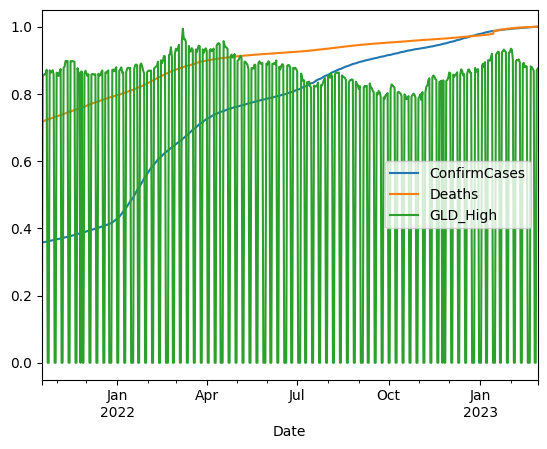

In [262]:
merged_dataFrame.tail(500).plot(x="Date", y=["ConfirmCases", "Deaths","GLD_High"])

<Axes: xlabel='Date'>

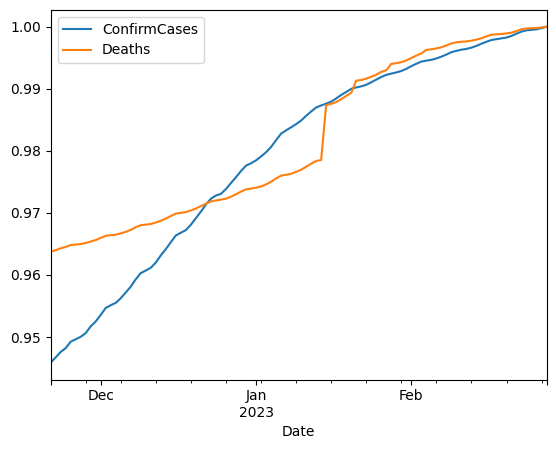

In [263]:
merged_dataFrame.tail(100).plot(x="Date", y=["ConfirmCases", "Deaths"])

In [264]:
# Drop the useless columns from both DataFrames
confirmed_cases = pd.read_csv(confirmed_cases_url)
deaths = pd.read_csv(deaths_url)

# Drop the useless columns from both DataFrames
confirmed_cases = pd.read_csv(confirmed_cases_url)
deaths = pd.read_csv(deaths_url)

# Drop the useless columns from both DataFrames
confirmed_cases.drop(columns=["Province/State", "Lat", "Long"], inplace=True)
deaths.drop(columns=["Province/State", "Lat", "Long"], inplace=True)

confirmed_cases_grouped = confirmed_cases_df.groupby("Country/Region").sum()
deaths_grouped = deaths_df.groupby("Country/Region").sum()
serconfirmedcases = confirmed_cases_grouped.sum(axis=0)
serdeaths = deaths_grouped.sum(axis=0)
globalCaseDeath = pd.DataFrame({
    'date': serconfirmedcases.index,
    'Cases': serconfirmedcases[0:],
    'Deaths': serdeaths[0:]
})

#display(confirmed_cases_grouped)

# Deleting the first row whihc contains rabbish
globalCaseDeath = globalCaseDeath.iloc[1:]

# Converting the date into the right format
#globalCaseDeath['date'] = pd.to_datetime(globalCaseDeath.date)

# Filtering by the dates needed and since them are avaliable and using only until 2023-02-22 to have consistent range of dates
globalCaseDeath = globalCaseDeath[globalCaseDeath['date'] >= "2020-01-22"]
globalCaseDeath = globalCaseDeath[globalCaseDeath['date'] <= "2023-02-22"] 

#globalCaseDeath['sum'] = globalCaseDeath.drop('Country/Region', axis=1).sum(axis=1)
print (globalCaseDeath)
globalCaseDeath.columns

Empty DataFrame
Columns: [date, Cases, Deaths]
Index: []


<ipython-input-264-bb187803c048>:13: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

<ipython-input-264-bb187803c048>:14: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



Index(['date', 'Cases', 'Deaths'], dtype='object')

In [265]:
def plotChart(dfPrice, title, subtitleprice):
    # Create subplots and mention plot grid size
    fig = make_subplots(rows=1, cols=1, shared_xaxes=True, 
                vertical_spacing=0.08, 
                row_width=[0.5])

    # Plot Prices on 1st row
    fig.add_trace(    
        go.Scatter(
            x=dfPrice['date'],
            y=dfPrice['4. close'],
            showlegend=True,
            line=dict(color='green'),
            name="Prices",
        ), row=1, col=1
    )

    # Bar trace for volumes on 2nd row without legend
    fig.add_trace(
        go.Scatter(
            x=dfPrice['date'], 
            y=dfPrice['Cases'], 
            showlegend=True,
            line=dict(color='steelblue'),
            name="Cases",
        ), row=1, col=1)

    fig.add_trace(
        go.Scatter(
            x=dfPrice['date'], 
            y=dfPrice['Deaths'], 
            showlegend=True,
            line=dict(color='red'),
            name="Deaths",
        ), row=1, col=1)

    # Do not show Price rangeslider plot 
    #fig.update(layout_xaxis_rangeslider_visible=False)

    fig.update_layout(title=title, 
                    yaxis_title="Variation",
                    width=1080,
                    height=720)

    fig.show()

In [267]:
def getPrices(symbolId):
    import datetime

    # Getting the indexes of overall american market and overall canadian market
    from alpha_vantage.timeseries import TimeSeries
    ts = TimeSeries(key='TC54JI2GWZOZ8I0J', output_format='pandas')

    start_date = datetime.datetime(2020, 1, 21)
    end_date = datetime.datetime(2023, 2, 22)

    # Getting the daily values for SP500 US Market 500
    data_daily, meta_data = ts.get_daily_adjusted(symbol=symbolId, outputsize ='full')

    # Create a filtered dataframe, and change the order
    date_filter = data_daily[(data_daily.index > start_date) & (data_daily.index <= end_date)]
    dfPrice = date_filter.sort_index(ascending=True)
    dfPrice = dfPrice.reset_index()

    return dfPrice

In [268]:
df_SP500 = getPrices('SPY')
df_SP500['Date'] = pd.to_datetime(SPY_data.Date)
resultSP500 = pd.merge(left=df_SP500, right=globalCaseDeath, left_on='date', right_on='date')


In [273]:
def dfNormalization(df):
    from sklearn.preprocessing import MinMaxScaler

    minmax = MinMaxScaler()
    df[['4. close', 'Cases', 'Deaths']] = minmax.fit_transform(df[['4. close', 'Cases', 'Deaths']])

    return df

In [278]:
plotChart(normalizedSP500, "COVID Effect on Overall American Market (SP500)", "Cases and Deaths")